In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InstrumentClassifier(nn.Module):
    def __init__(self, num_classes):
        super(InstrumentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Conv Layer 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Conv Layer 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Conv Layer 3
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling
        self.fc1 = nn.Linear(64 * 32 * 32, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


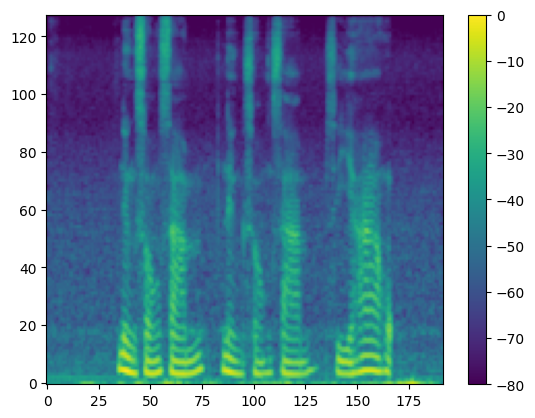

In [14]:
import librosa
import librosa.display
import torchaudio.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

def audio_to_melspectrogram(audio, sr=22050):
    if isinstance(audio, str):  # If input is a file path
        y, sr = librosa.load(audio, sr=sr)
    else:  # If input is a NumPy array (live audio)
        y = audio
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB
    return mel_spec_db

# Example usage:
mel_spectrogram = audio_to_melspectrogram(r"H:\DSP_project\ignoredir\data_test\Recording.wav")
plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
plt.colorbar()
plt.show()


In [16]:
mel_spectrogram.shape

(128, 192)

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class InstrumentDataset(Dataset):
    def __init__(self, file_list, labels):
        self.file_list = file_list
        self.labels = labels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = self.labels[idx]
        mel_spec = audio_to_melspectrogram(file_path)
        mel_spec = torch.tensor(mel_spec).unsqueeze(0)  # Add channel dimension
        return mel_spec.float(), torch.tensor(label)

# Define dataset and dataloader
file_list = ["guitar.wav", "bass.wav", "drum.wav"]  # Example paths
labels = [0, 1, 2]  # Example labels
dataset = InstrumentDataset(file_list, labels)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InstrumentClassifier(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):  # Train for 10 epochs
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    


In [ ]:
import sounddevice as sd
import numpy as np

def classify_live_audio(model, duration=1.0, sr=22050):
    print("Listening...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="float32")
    sd.wait()
    audio = audio.flatten()

    mel_spec = audio_to_melspectrogram(audio)
    mel_spec = torch.tensor(mel_spec).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(mel_spec)
        prediction = torch.argmax(output, dim=1).item()
    
    print(f"Predicted Instrument: {prediction}")

# Example usage:
classify_live_audio(model)


In [ ]:

df_meta_dev = pd.read_csv(r"H:\DSP_project\ignoredir\dataset\archive\fsd50k\FSD50K.metadata\collection\collection_dev.csv",
                      )
df_dev = pd.read_csv(r"H:\DSP_project\ignoredir\dataset\archive\fsd50k\FSD50K.metadata\collection\collection_dev.csv",
                      )



In [13]:
df_meta_dev.head()

,fname,labels,mids
0,64760,Electric_guitar,/m/02sgy
1,16399,Electric_guitar,/m/02sgy
2,16401,Electric_guitar,/m/02sgy
3,16402,Electric_guitar,/m/02sgy
4,16404,Electric_guitar,/m/02sgy


In [19]:
df_meta_dev["labels"].unique().size

1763